# Neuromodulator Imaging Analysis

In this notebook, we will simulate the dynamics of neuromodulator concentration and the resulting fluorescence signal. There are 4 parts:
- Simulation of a firing neuron, 
- Simulation of of a neuromodulator release and dynamics due to the firing neuron. 
- Simulation of the signal $\Delta F/F$ produced by the changes in neuromodulator concentration.
- Simulation of bleaching effects

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import bootstrap
from scipy.optimize import curve_fit

## 1. Simulation of firing neuron

Here, we define a function that simulates the activity of a single neuron. It takes the number of timesteps and firing rate of the neuron as arguments.

In [2]:
# define function that simulates a firing neuron

# it takes the number of timesteps(ms) + firing rate (Hz) as the argument
def simulate_neuron(n_timesteps, firing_rate):
    
    # generate a base array with random numbers between 0-1
    x = np.random.rand(n_timesteps)

    # Then populate the bins with signals - firing & not firing -- with a specific probability that you choose
    firing_neuron = x < 0.001*firing_rate
    firing_neuron = firing_neuron.astype(int)


    # then make a plot of it!
    plt.plot(firing_neuron)
    plt.xlabel('timesteps')
    plt.ylabel('Neuron activity')
    plt.title('Neuron Activity over {} timesteps'.format(n_timesteps))
    plt.show()


    # check exactly how many spikes were produced: to see if it works
    n_spikes = np.size(np.nonzero(firing_neuron))

    # print simulated neuron summary:
    print('Simulated neuron with {} spikes in {} timesteps ({} Hz).'.format(n_spikes, n_timesteps, firing_rate))
  

    return firing_neuron

# explicitly add dt = 1ms
# bonus: check at attosecond scale



Now let's visualize our firing neuron to see if we simulated it correctly

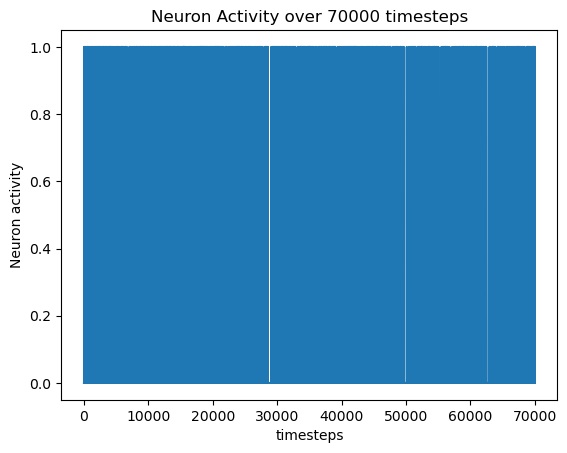

Simulated neuron with 905 spikes in 70000 timesteps (13 Hz).


In [3]:
# define the number of timesteps 
# each timestep / bin is 1 ms wide
firing_neuron = simulate_neuron(n_timesteps=70000,firing_rate=13)

Ok, look's like the neuron is firing as we expect it to over number of timesteps. (This section of code produced figure 1 on the interal note document.)

Bonus: run this function several times and histogram the n_spikes to see if it's actually a poisson w mean of n_timesteps spikes.


## 2. Simulation of Neuromodulator Dynamics

Now let's simulate a simple case of neuromodulator release caused by our firing neuron. Here, we assume that the neuromodulator release occurs instantaneously, and that we are dealing with one compartment and there's no uptake. 

### Modelling [NM] using numerical integration

At each timestep:
- take previous value of [NM]; if t = 0,  use $[NM]_0$, the resting level concentration
- update [NM] value: 
    - add the change in [NM], $\ \Delta[NM]_{\Tau}$ due to an action potential, if t is a 'firing_timestep';
    - if it's not a firing timestep then subtract the 'infinitesimal' change in [NM], $\ \frac{d[NM]}{dt}$, at that timestep

In [7]:
# define the time constant tau -- play with this number: needs to be in OrderM ~ 2
# find a way to like scroll thru different value of this number
# tau = 500 is a good estimate to be able to see the trend

# define the steady state value of nm_conc -- ask Kenta for this number


# define function that takes in an array of neuron activity and gives corresponding [NM]
def simulate_nm_conc(neuron_activity,nm_conc0, k_b,k_r,gamma):


    # create array of [NM] with same size as neuron activity
    nm_conc = np.zeros(neuron_activity.size)

    # define delta_nm, the increase in [NM] due to a spike 
    # this will be a constant value  -- calculate the amplitude of the exponential function, A
    delta_nm = 1
    
    # first define tau the time constant
    tau = (1+k_r+k_b)/gamma


    # create a for-loop where we update the value of [NM] for current timestep
    for t in range(neuron_activity.size):
        
        # first timebin condition
        if t == 0 : 
            nm_conc[t] = nm_conc0 
        else: 
            nm_conc[t] = nm_conc[t-1]

        # update [NM] value

        # if there's a spike add Delta_nm else subtract d_nm/dt the inifinitesimal decay in [NM] in one timestep 
        if neuron_activity[t]==1: 
            nm_conc[t] = nm_conc[t] + delta_nm
        else: 
            d_nm_dt =  (nm_conc[t]-nm_conc0)/tau
            nm_conc[t] = nm_conc[t] - d_nm_dt 

    # plot the [NM] at all timesteps
    n_timesteps = neuron_activity.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # Calculate the concentrations of the bound forms of the NM
    # start with [NM B] the NM bound to the sensor
    nm_b_conc = k_b*nm_conc

    # then [NM R], the NM bound to the receptor
    nm_r_conc = k_r*nm_conc

    # then get the total nm concentration - both bound and unbound
    nm_tot = nm_conc + nm_b_conc + nm_r_conc

    # plot [NM], [NM B] and [NM R] simulataneously
    plt.plot(t,nm_conc, color = 'b', label='[NM]')
    plt.plot(t,nm_b_conc, color = 'g', label='[NM B]')
    plt.plot(t,nm_r_conc, color = 'r', label='[NM R]')


    # label the axes and make legend
    plt.xlabel('time (ms)')

    # # to zoom in on a plot
    # plt.xlim(5000,15000)

    plt.ylabel('(Change in) Concentration -- arbitrary units')
    plt.title('NM concentration across {} ms'.format(n_timesteps))
    plt.legend()
    plt.show() 
   

    # return the array of the [NM], [NM B], and [NM R]
    return nm_conc, nm_b_conc, nm_r_conc, nm_tot

# DOCUMENT THE CALCULATION FOR THE BOUND SENSOR



### Details

We obtain the values for [NM] at different timesteps by solving an ODE originally used to describe calcium dynamics in chromaffin cells (Neher & Augustine 1992), but later modified to describe calcium dynamics in dendrites of pyramidal neurons (Sakmann 1996):


$ \begin{equation} 
    \frac{d}{dt} [NM]\ (1 + \kappa_r + \kappa_B) = \Delta [NM]_{\Tau}\ \delta (t - t_{AP}) - \gamma ([NM] - [NM]_0), 
\end{equation}
$

where $\kappa_r$ and $\kappa_B$ are the NM-binding ratios for the receptor and sensor respectively, $\Delta [NM]_{\Tau}$ is the instantaneous increase in the [NM] caused by an action potential at time $t_{AP}$, $[NM]_0$ is the initial/rest [NM] and $\gamma$ is a constant associated with how quickly the [NM] returns to its rest value (confirm this last definition of $\gamma$).

There's two solutions to this equation:
$\begin{equation} \tag{2}
\begin{cases}
\ \ A\ e^{-t/\tau}\ ,\ t\ge t_{AP} \\ 
\ \ \ \ \ 0 \ \ \ \ ,\ \ \ t < t_{AP}
\end{cases} \end{equation}
$

which give us the change in $[NM]_i$ from resting level,$\ \ \Delta [NM] (t)  = [NM] - [NM]_{rest}$, and we also know that when an action potential occurs, we get an instantaneous increase in [NM] given by $[NM]_{\Tau}$. 

The amplitude A, and the time constant $\tau$, are defined as follows:

$\begin{equation} \tag{3}
    A = \frac{\Delta [NM]_\Tau}{1+ \kappa_B + \kappa_r}, \ \ \ \tau = \frac{1+\kappa_B + \kappa_r}{\gamma} 
\end{equation}
$



To obtain the changes in concentrations for the NM bound to the sensor, $\Delta$ [NM B], and the NM bound to the receptor $\Delta$ [NM R], the following relations (from Neher & Augustine) were used:

$\begin{equation} \tag{4} 
    \Delta [NM\ B] = \kappa_B \ \Delta [NM]
\end{equation}
$

$\begin{equation} \tag{5}
    \Delta [NM\ R] = \kappa_r \ \Delta [NM]
\end{equation}
$
Now let's test if our simulation for the concentrations are plausible.

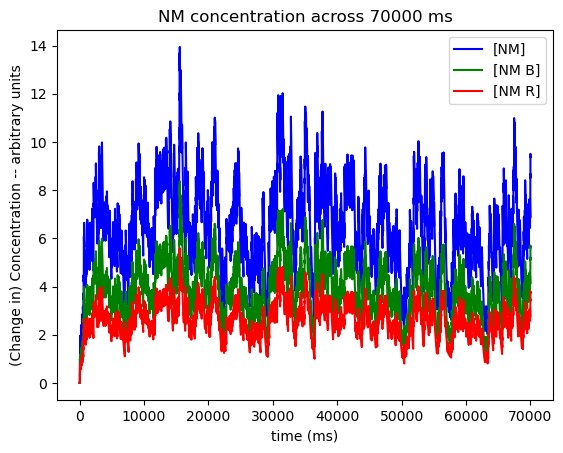

In [10]:
nm_conc, nm_b_conc, nm_r_conc, nm_tot = simulate_nm_conc(firing_neuron,nm_conc0=0,k_b=0.6, k_r=0.4,gamma=0.004)

Looks plausible from this scale. 
Next , let's try and zoom in and see the dynamics more closely.
(Previous cell can be used to reproduce fig 2 on internal note).

In [11]:
# Takes in the 1st and last timebins that will be the bounds of the plot
# Produces a plot within those timesteps
def plot_nm_conc(nm,start,stop,colour='b', plotlabel = ''):

    # define the timesteps to plot the [NM]
    timesteps = stop - start + 1
    t = np.linspace(start,stop,timesteps)

    # get that section of the [NM] array
    nm_section = nm[start:stop+1]

    # plot the [NM] 
    plt.plot(t,nm_section, color=colour, label=plotlabel)
    plt.xlabel('time (ms)')
    plt.ylabel('NM concentration')
    plt.title('NM {} concentration from {} to {} ms'.format(plotlabel, start,stop))
    plt.show()

    #BONUS: plot the neuron activity corresponding to this time interval
    # right above the nm_conc plot



This function also allows us to separate the three different concentrations plot. You can view the whole range of any of the concentrations by changing the start and stop values to 0 and the last time value.

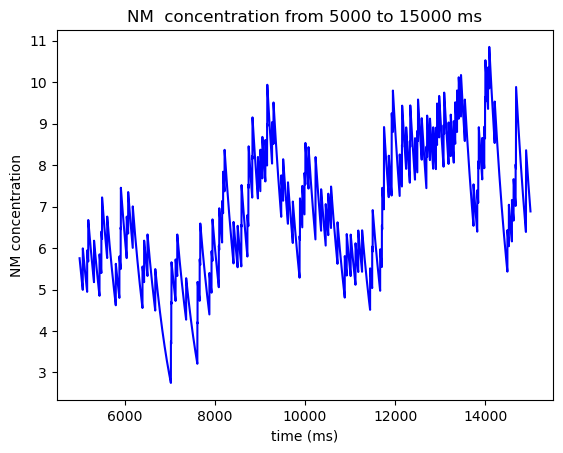

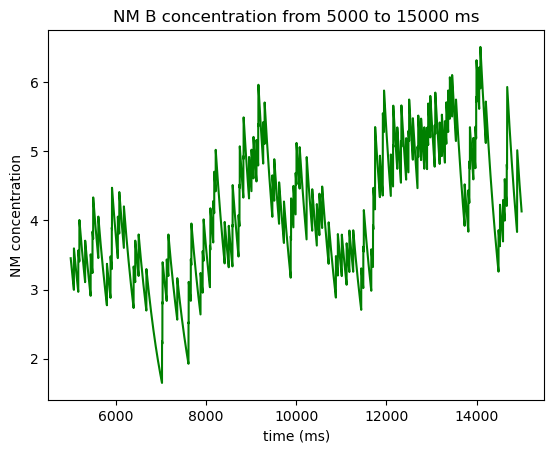

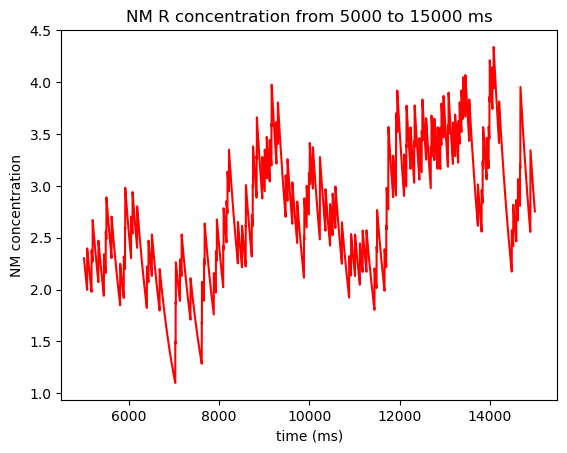

In [12]:
# Call the function on the different concentrations and change their start/stop values
plot_nm_conc(nm_conc, start = 5000,stop = 15000)
plot_nm_conc(nm_b_conc, start = 5000,stop = 15000, colour='g', plotlabel='B')
plot_nm_conc(nm_r_conc, start = 5000,stop = 15000, colour='r', plotlabel='R')

So far, the dynamics look plausible.

## 3.  Simulation of Fluorescence Signal

Now, let's simulate the flourescence signal produced by the changes in the neuromodulator concentration, $\ \Delta$ [NM]. This is described by eq. 3 in the paper by Neher/Augustine -- 1992: 

$\begin{equation}
    \frac{\Delta F(t)}{F(0)} = \frac{(K'_D + [NM]_{t})/(K_D + [NM]_{t})}{(K'_D + [NM]_{0})/(K_D + [NM]_{0})} - 1
\end{equation}
$

where $K_D$ is the dissociation constant for the NM binding to the sensor, $\ [NM]_{0}\ $ is the initial (resting) [NM], $\ [NM]_{t}\ $ is the [NM] for the current timestep, and $K'_D$ is defined as:

$\begin{equation} \tag{2}
    K'_D = K_D\ (F_{min}/F_{max})
\end{equation}
$

where $\ F_{max}\ $ is the fluorescence when the sensor is completely bound to the NM and $\ F_{min}\ $ is the fluorescence when the sensor is completely unbound to the NM (unlike in what was described in the Neher/Augustine 1992 paper, where they used a 'negative sensor' such that the definition of $\ F_{max}\ $ and $\ F_{min}\ $ were switched).

The dissociation constant $K_D$ is related to the previously seen NM-binding ratio for the sensor as follows:

$\begin{equation}\tag{3}
    \kappa_B = \frac{K_D [B]_{tot}}{(K_D + [NM])^2}
\end{equation}$

where $[B]_{tot}$ is the total concentration of the sensor. Combining equation 4 seen earlier in section 2, with equation 3 above, we get:

$\begin{equation}\tag{4}
    \kappa_B = \frac{\Delta [NM\ B]}{\Delta [NM]} = \frac{K_D [B]_{tot}}{(K_D + [NM])^2}
\end{equation}$


In the limit where the [NM] is very small, the relation becomes:

$\begin{equation}\tag{5}
    \kappa_B = \frac{[B]_{tot}}{K_D}
\end{equation}$


In [13]:
# GET ACTUAL VALUES FROM KENTA

# function takes in 3 constants used in the equation to calculate F from [NM]:
    # 1.The dissociation constant for the NM binding to the sensor,K_D
    # 2.The fluorescence when sensor is completely bound to NM, F_max (positive sensor)
    # 3.The fluorescence when sensor is completely unbound to NM

def simulate_fluorescence_signal(K_D, F_max, F_min, nm_conc):
    
    # define K_D prime as
    K_Dp = K_D*(F_min/F_max)

    # the initial/steady state concentration, [NM]i,0, of the neuromdultor
    # CONFIRM VALUE FROM KENTA
    nm_conc_0 = 0 

    # define the numerator and denominator
    numerator = (K_Dp + nm_conc)/(K_D + nm_conc)
    denominator = (K_Dp + nm_conc_0)/(K_D + nm_conc_0)

    # derive delta f/f0 by plugging in
    delta_ft_f0 = (numerator/denominator) - 1

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_ft_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Fluorescence intensity signal over time')

    return delta_ft_f0


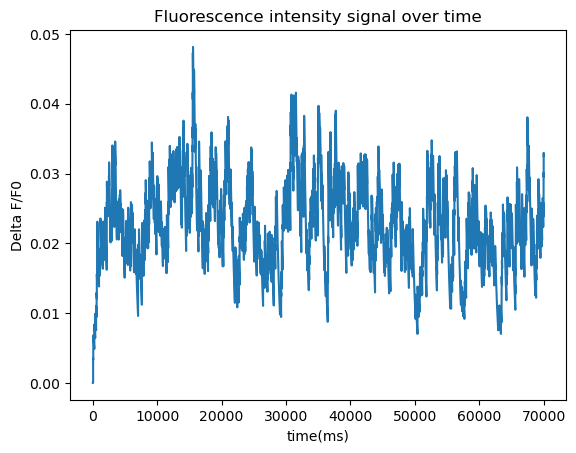

In [14]:
nm_conc_input = nm_conc
f_signal = simulate_fluorescence_signal(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input)

### Underlying relationship between the fluorescence signal and [NM]

Now, let's see how changing the signal produced corresponds to [NM]. 

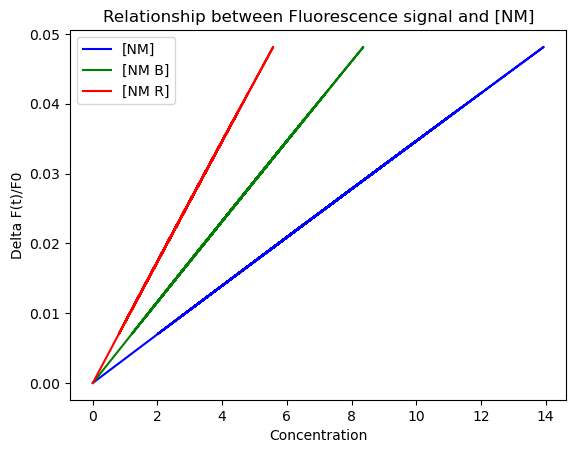

In [15]:
# plot the delta f vs the concentration

plt.plot(nm_conc,f_signal,color='b', label = '[NM]')
plt.plot(nm_b_conc,f_signal, color='g',label = '[NM B]')
plt.plot(nm_r_conc,f_signal, color='r',label = '[NM R]')
plt.xlabel('Concentration')
plt.ylabel('Delta F(t)/F0')
plt.title('Relationship between Fluorescence signal and [NM]')
plt.legend()


This linear relation confirms that the signal and changes in neuromodulator concentration producing this signal are directly related (sanity check).


### 3.1 Alternate $\Delta F/ F$ calculation: using the normalized f(t) - f(0) method

This is actually the standard way to calculate the df/f signal but since this analysis began with the relation between the [NM] and fluorescence, this method will be referred to as the alternate method in this notebook.

Given value of fluoresence F, the formula to calculate the normalized signal $\Delta F/F$ is 
$\begin{equation}\tag{3}
    \frac{\Delta F}{F} (t) = \frac{F(t) - F_0 }{F_0}
\end{equation}
$


F is calculated from a formula that was derived from eq. 2 in Neher/Augustine:

$\begin{equation}\tag{4}
    F = \frac{K_D F_{min} + [NM] F_{max}}{K_D + [NM]}
\end{equation}
$

If we account for the autofluorescnce of the tissue, this value is increased by a constant factor $f_{tissue}$ and we can get the fluorescence as a function of time:

$\begin{equation}\tag{5}
F(t) = f_{tissue} + \frac{K_D F_{min} + [NM](t)\ F_{max}}{K_D + [NM](t)}
\end{equation}
$

In [16]:
# Define alternate function to simulate fluorescence
def alternate_simulate_f_signal(K_D, F_max, F_min, nm_conc):

    # noisy autofluorescence
    f_tissue = np.random.normal(0.002,0.0005,nm_conc.size)

    # calculate F: derived from eq 2 in Neher/Augsutine
    f = f_tissue + (K_D*F_min + nm_conc*F_max)/(K_D + nm_conc)


    # calculate f0 by getting the median value of the bottom 70% of previous f values
    percentile_mark = np.percentile(f,70)
    f0 = np.median(f[f<percentile_mark])
    
    # df calc -- median value method
    df = f-f0
    df_f_med = df/f0


    # calculate normalized signal: (assume f0 is the initial f value)
    delta_ft_f0 = (f-f[0])/f[0]

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,df_f_med)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')

    return delta_ft_f0

These two code cells (below and above) are used to produce fig. 3 on the internal note.

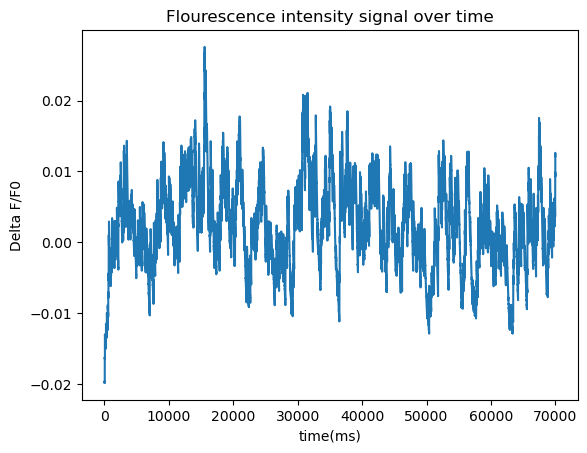

In [17]:
# Let's check if it's working now

alternate_f_signal = alternate_simulate_f_signal(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input)

### 3.2 Computing  F0 using a moving baseline

This method will not yield simimlar values to the other two values by definition. But the hope is that the updates in the F0 value will account better for the bleaching artifact. The F0 value simulated in the following cell was calculated by getting the average f values in a sliding window.

In [21]:
def simulate_f_signal_bline(K_D, F_max, F_min, nm_conc, bline_len):

    # calculate F: derived from eq 2 in Neher/Augsutine
    f = (K_D*F_min + nm_conc*F_max)/(K_D + nm_conc)
    

    # define the signal array
    delta_ft_f0 = np.zeros(f.size)


    # calculate f0 values and populate the signal array
    for i in range(f.size):

        # calculate f0 by averaging the previous x number of f values
        # if x is bigger than the current index then use all the prev f values
        # where x is the length of the moving baseline

        if i < bline_len:
            f0 = np.average(f[:i])
        else: 
            f0 = np.average(f[i-bline_len:i])

        # calculate normalized signal using the calculated f0
        delta_ft_f0[i] = (f[i]-f0)/(f0)


    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_ft_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')

    return delta_ft_f0

# BONUS: use weighted average to calculate the baseline later on

/Users/brian.gitahi/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/brian.gitahi/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


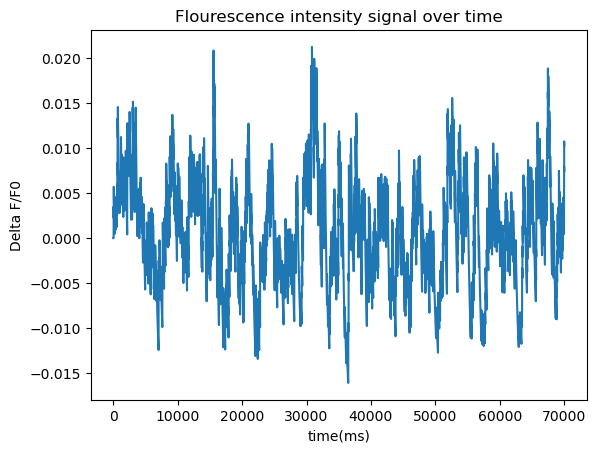

In [23]:
bline_f_signal = simulate_f_signal_bline(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input,bline_len=5000)

Let's try the same thing but calculate the baseline in a more 'standard' way. We're going to calculate the F0 value to use by taking the median value of the bottom 70% of the previous x values of f.

## 4. Bleaching Analysis

Recall the formula we used to calculate the observed fluorescence:

$\begin{equation}
F(t) = f_{tissue} + \frac{K_D F_{min} + [NM](t)\ F_{max}}{K_D + [NM](t)}
\end{equation}
$

In this section, we will apply a bleaching factor to the different terms in this fluorescence expression. We do this by individually bleaching the terms in the fluorescence equation:

$\begin{equation}\tag{2}
    F(t) = \gamma_{t}\ f_{tissue}  + \gamma_{nm}\ \frac{K_D F_{min} +  [NM](t)\ F_{max}}{K_D + [NM](t)} 
\end{equation}
$ where $\gamma_{t}$ and $\gamma_{nm}$ are the  exponential bleach factors applied to the individual sources of fluorescence given by:

$\begin{equation}\tag{3}
    \gamma_t = e^{-t/\tau_t}\ \ ,\ \ \ \gamma_{nm} = e^{-t/ \tau_{nm}} .
\end{equation}$ Here, the time constants,  $\tau_t$ and $\tau_{nm}$, are what we use to alter the strength of the bleach factors i.e., a stronger bleach has a smaller time constant.

 This will allow us to analyse the effects of bleaching from different contributions of fluorescence.

 Another key change is that we have now updated the way we calculate the F0 value. A standard way of performing this calculation is by taking the median value of the bottom 70% of the previous x values of f on the moving baseline.

Thes 2 major changes are implemented in the following cell:

In [24]:
def simulate_f_signal_bline2(tau_d, tau_nm, tau_tissue, nm_conc=nm_conc_input, K_D = 1000, F_max = 45, F_min = 10, bline_len=5000):

    # noisy autofluorescence
    f_tissue = np.random.normal(0.002,0.0005,nm_conc.size)

    # create timesteps 
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps) 

    # define bleach factors for the autofluorescence and fluorescence from dye + nm
    bleach_d = np.exp(-t/tau_d)
    bleach_nm = np.exp(-t/tau_nm)
    bleach_tissue = np.exp(-t/tau_tissue)
    
    # calculate F: derived from eq 2 in Neher/Augustine
    f = bleach_tissue*f_tissue + (bleach_d*K_D*F_min + bleach_nm*nm_conc*F_max)/(K_D + nm_conc)


    # fit an exponential to remove the bleaching trend 

    # define an exponential function that we'll use as the basis for the fit
    def exp_decay(t,a,b):
        return a*np.exp(-t/b)

    # perform the fit
    params, covariance = curve_fit(exp_decay,t,f)

    # get the parameters
    a_fit, b_fit = params

    # define the fitted function
    fit = exp_decay(t,a_fit,b_fit)
    
    # subtracted f
    f_subtracted = f - fit


    # to correct for negative values in the fluorescence that result in a -ve df/f
    f_alt = f_subtracted + np.max(np.abs(f_subtracted))

    
    # calculate f0 by getting the median value of the bottom 70% of previous f values
    percentile_mark = np.percentile(f,70)
    f0 = np.median(f[f<percentile_mark])
    
    # df calc -- median value method
    df = f-f0
    df_f_med = df/f0


    # df/f with the subtracted formula
    # subtracted signal
    percentile_mark_prime = np.percentile(f_alt,70)
    f0_sub = np.median(f_alt[f_alt<percentile_mark_prime])
    df_sub = f_alt - f0_sub
    
    df_f_med_sub = df_sub/f0_sub
    

    # define the delta f and the df/f signal arrays
    df_f_ave = np.zeros(f.size)
    f0_averages = np.zeros(f.size)
    

    # calculate f0 values and populate the signal array
    for i in range(f.size):

        # calculate f0 using the average method
        if i==0:
            f0_ave=f[0]
        
        elif i < bline_len:
            f0_ave = np.average(f[:i]) 
        else: 
            f0_ave = np.average(f[i-bline_len:i]) 

        # calculate normalized signal using the calculated f0
    
        # average value
        df_f_ave[i] = (f[i] - f0_ave)/f0_ave
        f0_averages[i]=f0_ave

    # define progression arrays for f, df, df/f
    progression = []
    progression_sub = []
    #progression_multi = []

    # without the subtracted exponent
    progression.append(f)
    progression.append(df)
    progression.append(df_f_med)
    progression.append(df_f_ave)

    # with the subtracted exponent
    progression_sub.append(f)
    progression_sub.append(f_alt)
    progression_sub.append(df_sub)
    progression_sub.append(df_f_med_sub)


    return progression, progression_sub, fit

    

Notice that we still have the average of the moving baseline version of F0 as well. This is purely for comparison purposes between the 2 calculations of F0. From now onwards the preferred method is the 'median value' method.

Plot the progression: f until df/f
(used to produce fig. 4 in the interal note)

In [25]:
# plot the progression from f -- df/f
def plot_f_signal(progression, progression_sub, fit):


    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    plt.figure(1)
    plt.subplot(2,2,1)
    plt.plot(t,progression[0], label='f')
    plt.xlabel('time (ms)')
    plt.ylabel('f')
    plt.title('f  vs time')
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(t,progression[1], label='df')
    plt.xlabel('time (ms)')
    plt.ylabel('df')
    plt.title('df vs time (f0:median)')
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(t,progression[2], label = 'df/f')
    plt.xlabel('time(ms)')
    plt.ylabel(' df/f')
    plt.title('df/f vs time (f0:median)')
    plt.legend()
   
    plt.subplot(2,2,4)
    plt.plot(t,progression[3], label = 'df/f')
    plt.xlabel('time(ms)')
    plt.ylabel(' df/f')
    plt.title('df/f vs time (f0:average)')
    plt.legend()
    plt.suptitle('Progression from f to df/f', size = 16)
    plt.tight_layout()

    plt.figure(2)
    plt.subplot(2,2,1)
    plt.plot(t,progression_sub[0], label='f')
    plt.xlabel('time (ms)')
    plt.ylabel('f')
    plt.title('f  vs time')
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(t,progression_sub[2], label = 'df')
    plt.xlabel('time(ms)')
    plt.ylabel(' df')
    plt.title('df vs time (f0:median)')
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(t,progression_sub[3], label = 'df/f')
    plt.xlabel('time(ms)')
    plt.ylabel(' df/f')
    plt.title('df/f vs time (f0:median)')
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(t,progression_sub[1], label='f - exponential (+ constant)')
    plt.xlabel('time (ms)')
    plt.ylabel('f_sub')
    plt.title('f_sub vs time')
    plt.legend()
    
    plt.suptitle('Progression from f to df/f (using subtracted f)', size = 16)
    plt.tight_layout()





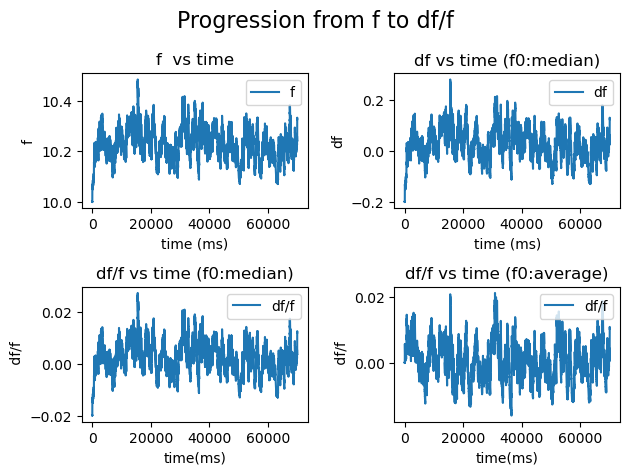

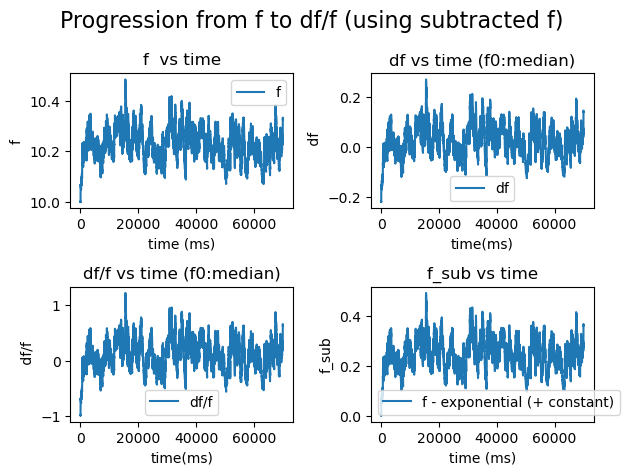

In [26]:
# simulate the fluorescence signal and plot -- equal bleaching in the dye and nm contributions
progression, progression_sub, fit  = simulate_f_signal_bline2(tau_d=10e9,tau_nm=10e9, tau_tissue=10e9)
plot_f_signal(progression, progression_sub, fit)

We can also show how to correct for the bleaching effect -- normally a step that happens in the processing of the generated df/f signal. This is done by fitting the signal with a polynomial and subtracting it from the signal to remove the exponential trend.
(Shown a couple of cells below)

### 4.1 Visualising the relationship between bleaching and the signal produced using heatmaps

Next, we make a function to analyse the bleaching effect for all combinations of two bleach factors
and outputs a heatmap to show effects of bleaching different sources of the f value. (the following cells are used to produce Figure 7 on the internal note)

In [27]:
def bleach_dnm(tau_values):

    # create an array to store the snr values
    snr = np.zeros((tau_values.size, tau_values.size))

    # BONUS: find way to do it that's more effecient -- this is O(n^2)
    for i in range(len(tau_values)):
        for j in range(len(tau_values)):
            progression, progression_sub, fit = simulate_f_signal_bline2(tau_d=tau_values[i],tau_nm=tau_values[i], tau_tissue=tau_values[j])
            snr[i,j] = np.abs(np.mean(progression_sub[3])/np.std(progression_sub[3]))
            #print(np.std(signal[3])) -- for testing
    
    # use log tau values to make a simple scale
    log_tau_values = np.log10(tau_values)

    print(snr)

    # Generate the heatmap
    start, stop = log_tau_values[0], log_tau_values[-1]
    plt.imshow(snr, cmap='magma', extent=[start, stop, stop, start])
    plt.colorbar(label='signal to noise ratio')
    plt.xlabel('bleach time constant in tissue  fluorescence')
    plt.ylabel('bleach time constant in dye + nm flourescence')
    plt.title('Signal to noise ratio for different bleach factor combinations')
    plt.show()

    return snr

# get values of SNR for increasing bleach factor ([NM] version) at different values of bleach factor (tissue version)


In [44]:
# generating sets of time constant values to test the heatmap
different_taus = np.logspace(2,11,10)

few_taus = np.logspace(2,6,5)
specific_taus = np.logspace(5,7,20)

In [29]:
# checking if the mean and sd of the signal are plausible before generating the heatmap
test_signal1, test_signal2, fit = simulate_f_signal_bline2(tau_d=different_taus[1],tau_nm=different_taus[1], tau_tissue=different_taus[0])

print('mean is {}'.format(np.mean(test_signal1[3])))
print('std is {}'.format(np.std(test_signal1[3])))

mean is -0.9454367388966861
std is 0.10428199404127482


[[0.06717555 0.06618183 0.06264375 0.05736775 0.05176968 0.04693067
  0.04370414 0.04180429 0.04106421 0.04120711 0.04269175 0.04375783
  0.04499386 0.0463172  0.04743494 0.04842213 0.04988103 0.05025485
  0.05077535 0.05126282]
 [0.11703164 0.11759535 0.11709354 0.11520309 0.11313306 0.11077959
  0.10841316 0.10741298 0.10646459 0.10738479 0.10780688 0.10897186
  0.11045479 0.11214231 0.11239059 0.11422817 0.11418472 0.11568145
  0.11610881 0.11625904]
 [0.17898678 0.18044129 0.1809537  0.18075348 0.17975175 0.17871343
  0.17840966 0.17778311 0.17822261 0.17926211 0.18026529 0.18107003
  0.18184642 0.18258301 0.18369397 0.18443562 0.18509142 0.18502758
  0.18517441 0.18570684]
 [0.25204429 0.25323305 0.25440027 0.25419    0.25392892 0.25333816
  0.25262543 0.25182072 0.25177078 0.2517552  0.25203857 0.25291685
  0.25368706 0.25374667 0.25460208 0.25465794 0.25508146 0.25549134
  0.25595405 0.25609767]
 [0.32469474 0.32635033 0.32772963 0.32838404 0.3285825  0.32836611
  0.32812227 0.3

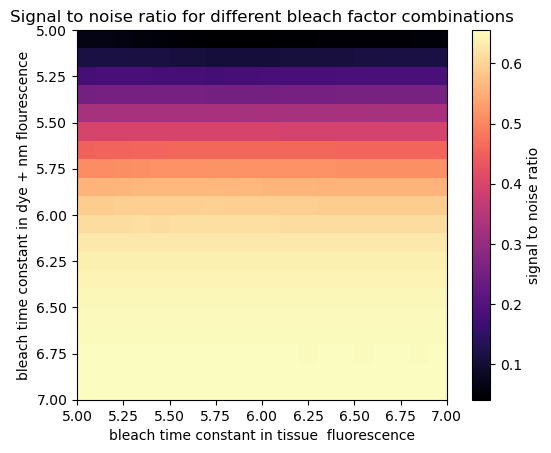

In [43]:
# run the simulation with different bleach factors on the different sources of fluorescence
snr_tissue_vs_dnm = bleach_dnm(specific_taus)

So it looks like bleaching the autofluorescence contribution to f has no effect on the signal to noise ratio while bleaching the combined sensor and nm contribution has an effect (can also refer to it as the bound and unbound neuromodulator). This analysis was extended to take into account different amounts of variance in the autofluorescence. Cf Analysis #2 in the bleach_compare.py script. (this script was used to produce figure 8 on the interal note)

We can check this manually in the next cell by running the cell with different values for tau_d/tau_nm and tau_tissue. Tau_d and Tau_nm values are set to be the same at all iterations (it doesn't quite make sense to bleach them independently -- but it's intuitively helpful to check and see that bleaching the sensor term has more of an effect on the observed signal than bleaching the nm term).

(Used to produce fig 5 and 6 in the internal note)

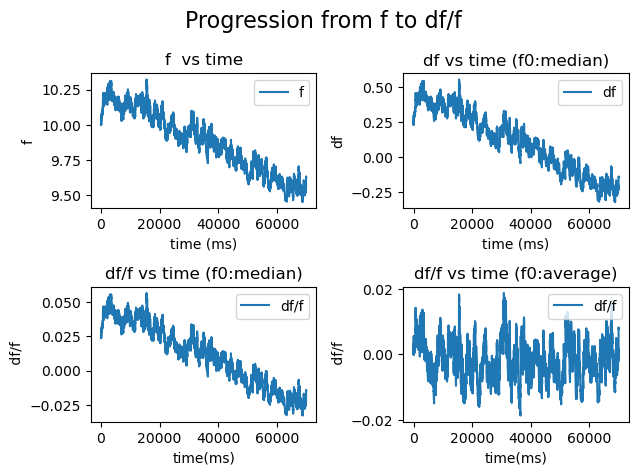

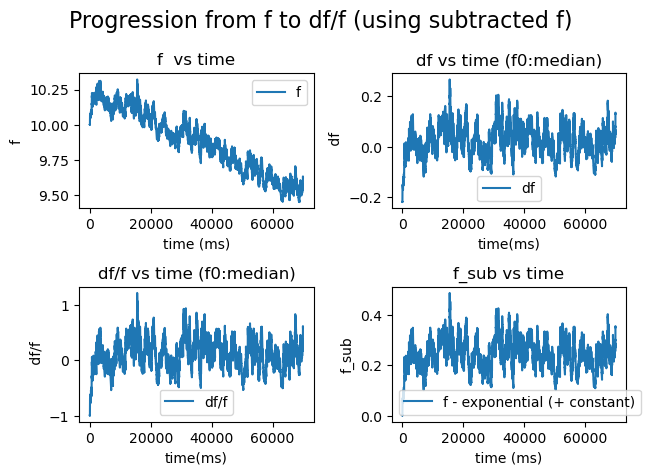

In [31]:
# simulate the fluorescence signal and plot
# you can run this cell multiple times, changing the tau_d/tau_nm values
progression, progression_sub, fit = simulate_f_signal_bline2(tau_d=10e5,tau_nm=10e5, tau_tissue=10e9)
plot_f_signal(progression, progression_sub, fit)

Now let's look directly at one of the bleach factors and its effect on the signal to noise ratio. To do this we plot the signal to noise ratio against the bleach time constants for the two fluorescent terms as shown. (the following code cells are used to produce figures 9 and 10 on the interal note)

NB: Motion on the x-axis towards the positive direction shows a decrease in the bleach factor strength (larger time constants translate into slower bleaching).

In [45]:
# Let's make a function that runs the calculation to get the snr at various bleach factors several times
# and reports errorbars for the resulting plot

def snr_bleach(tau_values,n_samples):

    # define the results arrays: will contain the errorbar values
    results_nm = []
    results_t = []
    
    # define the snr arrays
    snr1 = np.zeros(n_samples)
    snr2 = np.zeros(n_samples)

   
    # obtain the signal -- apply the given bleach factors to the nm + dye / bound and unbound contribution
    for i in range(len(tau_values)):
        
        # get multiple values for the snr at each bleach factor
        for j in range(0,n_samples):
            # obtain the bleached signal
            progression, progression_sub, fit = simulate_f_signal_bline2(tau_d=tau_values[i], tau_nm=tau_values[i],tau_tissue=10e7)

            # compute the snr
            snr1[j] = np.abs(np.mean(progression_sub[3])/np.std(progression_sub[3]))
        
        # generate the error bar values: mean + upper and lower bound
        #res1 = bootstrap((snr1,), np.mean, confidence_level=0.99, random_state=13)
        snr1_best = np.mean(snr1)
        #snr1_low = np.mean(snr1) - res1.confidence_interval[0]
        #snr1_up =  res1.confidence_interval[1] - np.mean(snr1) 
        error1 = np.std(snr1)
        results_nm.append([snr1_best, error1])

    # print statement to show progress
    print('completed {} snr calculations for the nm contribution'.format(i))

    
    # obtain the signal -- apply the given bleach factors to the tissue contribution 
    for i in range(len(tau_values)):

        # get multiple values for the snr at each bleach factor
        for j in range(0,n_samples):
            # obtain the bleached signal
            progression2, progression_sub2, fit2 = simulate_f_signal_bline2(tau_d=10e7, tau_nm=10e7,tau_tissue=tau_values[i])

            # compute the snr
            snr2[j] = np.abs(np.mean(progression_sub2[3])/np.std(progression_sub2[3]))
        
        # generate the error bar values: mean + upper and lower bound
        #res2 = bootstrap((snr2,), np.mean, confidence_level=0.99, random_state=13)
        snr2_best = np.mean(snr2)
        #snr2_low = np.mean(snr2) - res2.confidence_interval[0]
        #snr2_up = res2.confidence_interval[1] - np.mean(snr2)
        error2 = np.std(snr2)
        results_t.append([snr2_best, error2])

    # print statement to show progress
    print('completed {} snr calculations for the tissue contribution'.format(i+1))
    
    return np.array(results_nm), np.array(results_t), tau_values

In [46]:
# define function to plot these results
def plot_snr_bleach(snr1, snr2, tau_values):

    # plot the snr for the different bleach factors on the same plot
    plt.figure(1)
    plt.errorbar(x=tau_values,y=snr1[:,0],yerr=np.transpose(snr1[:,1]), fmt='bo', label='nm + dye')
    plt.errorbar(x=tau_values,y=snr2[:,0],yerr=np.transpose(snr2[:,1]), fmt='go', label='tissue')
    plt.xlabel('bleach factor time constants')
    plt.ylabel('signal to noise ratio')
    plt.xscale('log')
    plt.title('snr vs bleach strength')
    plt.legend()


    # same plots but separately
    plt.figure(2)
    plt.subplot(2,1,1)
    plt.errorbar(x=tau_values,y=snr1[:,0],yerr=np.transpose(snr1[:,1]), fmt='bo')
    plt.xlabel('bleach factor time constants')
    plt.ylabel('signal to noise ratio')
    plt.xscale('log')
    plt.title('snr vs bleach strength (nm + dye)')

    plt.subplot(2,1,2)
    plt.errorbar(x=tau_values,y=snr2[:,0],yerr=np.transpose(snr2[:,1]), fmt='go')
    plt.xlabel('bleach factor time constants')
    plt.ylabel('signal to noise ratio')
    plt.xscale('log')
    plt.title('snr vs bleach strength (tissue)')
    plt.tight_layout()

In [47]:
space = np.logspace(5,7,7)

completed 6 snr calculations for the nm contribution
completed 7 snr calculations for the tissue contribution


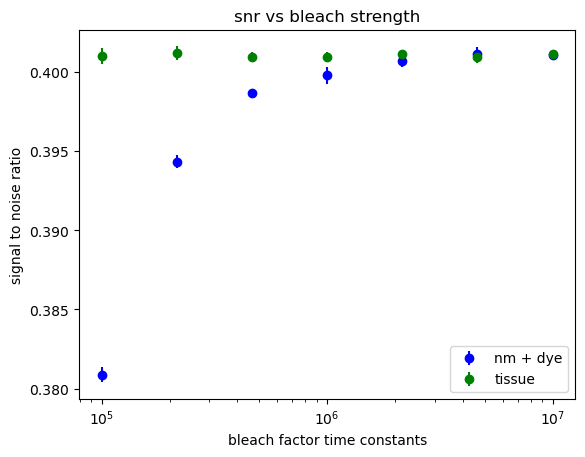

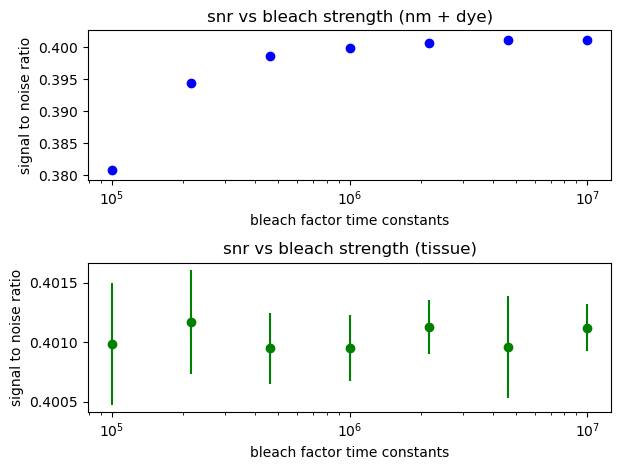

In [48]:
s1,s2, taus = snr_bleach(space,5)
plot_snr_bleach(s1,s2,taus)

### Observation

The trend that we see is that bleaching of the autofluorescence doesn’t have much of an effect on the signal to noise ratio. However, for bleaching in the bound and unbound neuromodulator, the signal to noise ratio improves as we decrease the bleach strength and then finally settles at a constant value. This further confirms our earlier finding from the heatmap analysis.

## 4.2 Firing Rate Analysis

This part of the analysis is mainly a sanity check to see that our simulation is running as expected.
Here, we expect that the firing rate of the neuron has a linear positive relation to the fluorescence signal observed, i.e. if the neuron fires more then we expect more fluorescence to be obsreved.

In [33]:
# try plot the df/f average vs the firing rate for a sliding window -- 100 ms

def dff_v_activity(neuron_activity, progression_array, window=100):

    number_blocks = int(progression_array[3].size/window)
    signal_points = []


    # array of neural activity
    firing_rate = []

    for block in range(number_blocks):

        # define the interval
        start = (block*window)
        stop = ((block+1)*window+1)

        # get average signal for 100 ms sliding window
        signal_average = np.average(progression_array[3][start:stop])

        # store it
        signal_points.append(signal_average)

        # Check the activity of the firing neuron for current window
        spikes = np.size(np.nonzero(neuron_activity[start:stop]))

        # convert it to Hz and add it to the firing rate array
        firing_rate.append(spikes*1000/100)


    # get the unique firing rates
    unique_frates = np.unique(firing_rate)

    # array to store the average dff values
    average_signal_points =[]

    # convert the list to an array
    signal_points = np.array(signal_points)



    # average the df/f values at each of the unique values
    for i in range(len(unique_frates)):

        # get the indices where the firing rate was a given value, x
        indices = np.where(firing_rate==unique_frates[i])[0]
        
        # average all the corresponding df/f values
        ave_dff = np.average(signal_points[indices])
        average_signal_points.append(ave_dff)


    # fit the average signal points 
    poly = np.polyfit(unique_frates,average_signal_points,1)
    fit = np.polyval(poly,unique_frates)

    plt.figure(1)  
    plt.plot(firing_rate,signal_points,'o')
    plt.xlabel('Firing rates(Hz)')
    plt.ylabel('Average df/f signal')
    plt.title('Signal vs activity plot')
    plt.show()


    plt.figure(2)
    plt.plot(unique_frates,average_signal_points,'o')
    plt.plot(unique_frates,fit, label='fit')
    plt.xlabel('Firing rates(Hz)')
    plt.ylabel('Average df/f signal')
    plt.title('Signal vs activity plot (average)')
    plt.legend()
    plt.show()



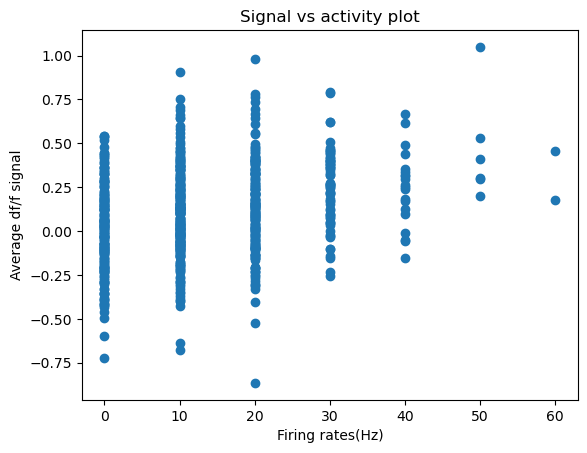

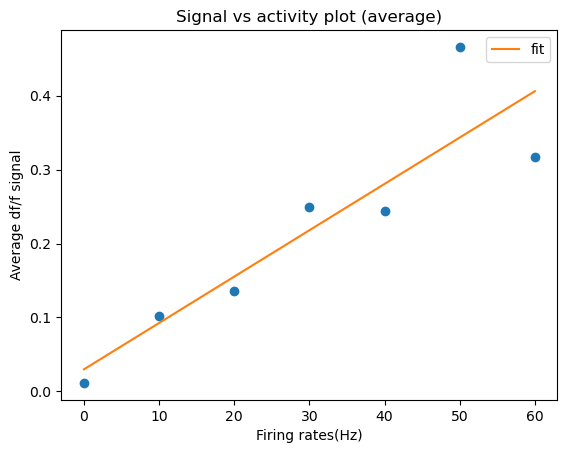

In [34]:
dff_v_activity(firing_neuron, progression_sub)

After averaging the signal values at each of the firing rates, we get a positive linear relationship between the firing rate and the signal -- as initially expected. This part of the analysis has its own scripts (used to generate figure 11) -- f_rate.py and f_rate2.py which can be used to analyse different neurons with different firing rates (as opposed to here where we used one neuron and subdivided itsd activity into time windows with different firing rates and fluorescence signals) -- the result is the same: a positive linear relationship.